# MIE1624 Tutorial 2 - Assignment 1 

In this tutorial, we will go over the following:
 - What is expected of by the assignment
 - Reading in data
 - String manipulation
 - Simple plots
 - Machine learning
     - preparing data
     - making predictions
     - validating model
     
**Note: All libraries are allowed except for those that do sentiment analysis, such as Watson Natural Language Processing**

#### Install necessary libraries

In [83]:
!pip install numpy
!pip install pandas
!pip install sklearn

## How to Read in Data

There are several ways to read data into a dataframe. Below, you can see how data can be read in using Python built in file read in method, and Panda's read_csv method.

### Python's open and read function
Here is an example of how Python open and read function can be used to read in a file into a list.

The open().read() function reads in the contents of a file into a string variable (in our case tweets).

In [84]:
tweets = open('tweets_dataset.csv','r').read()
tweets[0:500]

'tweet,sentiment\nHappy St. Patty\'s Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://t.co/hpOsiqG0jK #photo,0.267517\n"Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown, Ontario) https://t.co/nEAyFYFxkd",0.456975\nTrudeau government gifts $650 millions overseas to \'kill\' life and/or prevent procreation.He offers $120 million to feed the world in hunger,-0.283957\n"Thai food is HOT tonight (@ Pai in Toronto, ON w/ @tsangzillavs) https://t.co/Y1rqDVLib9",-0.43'

Now to split this string input into a list with each element containing a line of the file, we can use the split function. The split function will split a string wherever it finds the string argument passed to it. E.g, str.split('.') will split the str wherever it finds a '.'. In our case, to split by line, we split by the newline handle '\n' which can be seen in the output above.

In [85]:
tweetsList = tweets.split('\n')
tweetsList[0:5]

['tweet,sentiment',
 "Happy St. Patty's Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://t.co/hpOsiqG0jK #photo,0.267517",
 '"Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown, Ontario) https://t.co/nEAyFYFxkd",0.456975',
 "Trudeau government gifts $650 millions overseas to 'kill' life and/or prevent procreation.He offers $120 million to feed the world in hunger,-0.283957",
 '"Thai food is HOT tonight (@ Pai in Toronto, ON w/ @tsangzillavs) https://t.co/Y1rqDVLib9",-0.433962']

In [86]:
tweetsList[-3:]

['RT @CTVToronto: Toronto police searching for missing elderly man with dementia https://t.co/guwZ8FhGlJ https://t.co/BKb6u8mV6o,-0.390022',
 "Oh ❤break. Rock+Roll legend Chuck Berry has died: https://t.co/uXFmAnLLcB I ❤'d him..but I've a friend who idolized him..he'll be crushed.,-0.792687",
 '']

We will drop the first element (first line) because it only contains the headings of the documents, and we will drop the last element because it is empty.We can acheive this using the del function.

In [87]:
del tweetsList[0] # delete first element
del tweetsList[-1] # delete last element
print (tweetsList[0:5])
print (tweetsList[-2:])

["Happy St. Patty's Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://t.co/hpOsiqG0jK #photo,0.267517", '"Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown, Ontario) https://t.co/nEAyFYFxkd",0.456975', "Trudeau government gifts $650 millions overseas to 'kill' life and/or prevent procreation.He offers $120 million to feed the world in hunger,-0.283957", '"Thai food is HOT tonight (@ Pai in Toronto, ON w/ @tsangzillavs) https://t.co/Y1rqDVLib9",-0.433962', '"The iconic Zanzibar (pictured here) has been ordered by the City of Toronto, to take down its tv screen due to city? https://t.co/qXP5pjVGym",0.568962']
['RT @CTVToronto: Toronto police searching for missing elderly man with dementia https://t.co/guwZ8FhGlJ https://t.co/BKb6u8mV6o,-0.390022', "Oh ❤break. Rock+Roll legend Chuck Berry has died: https://t.co/uXFmAnLLcB I ❤'d him..but I've a friend who idolized him..he'll be crushed.,-0.792687"]


In [88]:
tweetsList[2]

"Trudeau government gifts $650 millions overseas to 'kill' life and/or prevent procreation.He offers $120 million to feed the world in hunger,-0.283957"

In [89]:
tweetsList[3]

'"Thai food is HOT tonight (@ Pai in Toronto, ON w/ @tsangzillavs) https://t.co/Y1rqDVLib9",-0.433962'

We can see that each line has the sentiment score stored at the end of the tweet separated by a comma. To separate this using for expressions. Here note that when splitting with commas, the commas in the tweet would also cause splits but since the sentiment is always at the end, the final element of split string is the sentiment. We can access the final element of the string by using '-1'. We will also typecast the sentiments which are currently stored as strings to floats.

We can also see the some tweets are led by " that we need to remove to cleanly read the string.

### Processing one tweet

Split string by commas

In [90]:
tweetsList[3].split(',')

['"Thai food is HOT tonight (@ Pai in Toronto',
 ' ON w/ @tsangzillavs) https://t.co/Y1rqDVLib9"',
 '-0.433962']

Select the first part of the string (ignoring the sentiment)

In [91]:
tweetsList[1].split(',')[:-1]

['"Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown',
 ' Ontario) https://t.co/nEAyFYFxkd"']

The tweet is currently stored inside a list in the first index. 

In [92]:
tweetsList[1].split(',')[:-1][0]

'"Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown'

Now strip the first character if it is a ".

In [93]:
tweetsList[1].split(',')[:-1][0].lstrip('"')

'Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown'

### Apply to all

In [94]:
tweets = [tw.split(',')[:-1][0].lstrip('"') for tw in tweetsList]
sentiments = [float(tw.split(',')[-1]) for tw in tweetsList]

In [95]:
print(tweets[0:5])

["Happy St. Patty's Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://t.co/hpOsiqG0jK #photo", 'Delicious fritters! (at @Copper_Kettle_ Cafe in Waterdown', "Trudeau government gifts $650 millions overseas to 'kill' life and/or prevent procreation.He offers $120 million to feed the world in hunger", 'Thai food is HOT tonight (@ Pai in Toronto', 'The iconic Zanzibar (pictured here) has been ordered by the City of Toronto']


In [96]:
print(sentiments[0:5])

[0.267517, 0.456975, -0.283957, -0.433962, 0.568962]


### Create a pandas dataframe

Now to convert these two lists into dataframes. We can use the following:

In [97]:
import pandas as pd

df = pd.DataFrame ({
        'tweets': tweets,
        'sentiment':sentiments
})

df.head()

,sentiment,tweets
0,0.267517,Happy St. Patty's Fri-yay! - Drinking a Guinne...
1,0.456975,Delicious fritters! (at @Copper_Kettle_ Cafe i...
2,-0.283957,Trudeau government gifts $650 millions oversea...
3,-0.433962,Thai food is HOT tonight (@ Pai in Toronto
4,0.568962,The iconic Zanzibar (pictured here) has been o...


### Panda's read_csv function

A simpler way to do the above is with Panda's read_csv function as seen below. This will read a csv file directly into a pandas dataframe. This may file if your file you're trying to read in isn't properly structured.

In [98]:
df = pd.read_csv('tweets_dataset.csv')
df.head()

,tweet,sentiment
0,Happy St. Patty's Fri-yay! - Drinking a Guinne...,0.267517
1,Delicious fritters! (at @Copper_Kettle_ Cafe i...,0.456975
2,Trudeau government gifts $650 millions oversea...,-0.283957
3,"Thai food is HOT tonight (@ Pai in Toronto, ON...",-0.433962
4,The iconic Zanzibar (pictured here) has been o...,0.568962


## String Manipulation
As part of these assignment, you have to remove elements from a string. There are a couple ways to do this. Here is how you can do it with Python's replace function.

For this example, we will use the first tweet of the dataframe and we will access it using Pandas '.iloc' function, which lets us access rows by index number.

In [99]:
tw = df.iloc[0]['tweet']
tw

"Happy St. Patty's Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://t.co/hpOsiqG0jK #photo"

### Python's replace Function
Here will use the replace function to replace periods(.) in the tweet with nothing (''). The replace function takes 2 arguments: (1) What to replace, and (2) What to replace it with.

In [100]:
tw.replace('.','')

"Happy St Patty's Fri-yay! - Drinking a Guinness Original Extra Stout (Canada / USA) @ EaDo - https://tco/hpOsiqG0jK #photo"

Please note, you don't need to do something as direct as this to clean your tweets. You can use pre-existing libraries for cleaning your tweets, such as nltk, an open-source natural language processing toolkit. For example, nltk has a method for removing stop words from strings that you may use. Alternatively, you may use the files provided to remove the stop words listed within it. 

## Exploratory Data Analysis

Here is an example of how you can visually analyze your data. First I will define negative tweets as any tweets that have a sentiment score less than 0 and label this as 0, and define positive tweets as any tweets that have a sentiment score greater than 0 and label this as 1.

To apply a function to a dataframe I can use the apply function. To define a function inline I can apply the lambda function. The lambda function will return 1 if the sentiment score is greater than 0 and 0 otherwise.

In [101]:
df['score'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,tweet,sentiment,score
0,Happy St. Patty's Fri-yay! - Drinking a Guinne...,0.267517,1
1,Delicious fritters! (at @Copper_Kettle_ Cafe i...,0.456975,1
2,Trudeau government gifts $650 millions oversea...,-0.283957,0
3,"Thai food is HOT tonight (@ Pai in Toronto, ON...",-0.433962,0
4,The iconic Zanzibar (pictured here) has been o...,0.568962,1


I will also define another column containing the length of the tweets called length:

In [102]:
df['length'] = df['tweet'].apply(len)
df.head()

,tweet,sentiment,score,length
0,Happy St. Patty's Fri-yay! - Drinking a Guinne...,0.267517,1,124
1,Delicious fritters! (at @Copper_Kettle_ Cafe i...,0.456975,1,91
2,Trudeau government gifts $650 millions oversea...,-0.283957,0,140
3,"Thai food is HOT tonight (@ Pai in Toronto, ON...",-0.433962,0,88
4,The iconic Zanzibar (pictured here) has been o...,0.568962,1,140


Now, here we will use the hist plot from pandas to do simple visualizations of our two new columns. You could alternatively use other visualization libraries like matplotlib or seaborn to create more intricate plots.

The following line is needed in notebooks to show plots inline.

In [105]:
import matplotlib.pyplot as plt

%matplotlib inline

First, lets plot the distribution of scores using pandas hist function.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f406c225240>]],
      dtype=object)

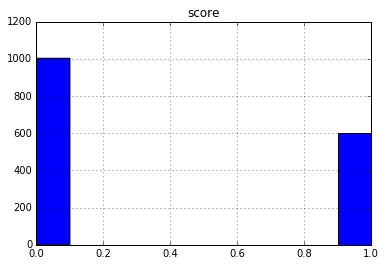

In [106]:
fig = plt.figure(figsize=(12,6))
df.hist('score')

From this, you can see that there are more negative tweets than positive tweets.

Now let's plot the histograms of length split by the score value.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f405f061240>,
      dtype=object)

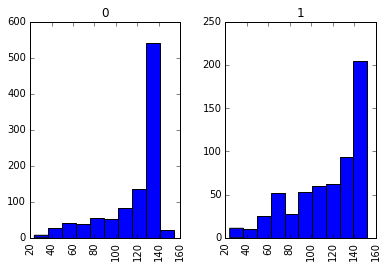

In [107]:
df.hist('length',by='score')

The distributions of length for both positive and negative are similar but the tail for positive tweets is more heavy than for negative tweets. A majority of the negative tweets are long.

## Machine Learning

Now, lets use our two new plots to do some machine learning using scikit-learn. 

Note: Scikit-learn requires numerical inputs. You cannot pass the tweets directly into the a model. You have to first convert the tweets to some sort of numerical format. You are welcome to use the 'corpus' scores provided to convert your tweets into a corpus score, or you may use something more involved like the TF-IDF vectorizer from scikit-learn. The method that you use can have a great impact on your machine learning results.

For the purposes of this tutorial, we will just use the length column to see if we can predict the score column.

### Splitting features/target variables

First, we will extract our features into the variable X, and our target into the variable y.

In [108]:
df

,tweet,sentiment,score,length
0,Happy St. Patty's Fri-yay! - Drinking a Guinne...,0.267517,1,124
1,Delicious fritters! (at @Copper_Kettle_ Cafe i...,0.456975,1,91
2,Trudeau government gifts $650 millions oversea...,-0.283957,0,140
3,"Thai food is HOT tonight (@ Pai in Toronto, ON...",-0.433962,0,88
4,The iconic Zanzibar (pictured here) has been o...,0.568962,1,140
5,Feel like Trump is wrong about having ANYTHING...,-0.746078,0,142
6,Buona Notte. Really interesting. Especially #...,0.578655,1,91
7,It's 'cos he doesn't admit that a woman can be...,-0.612578,0,140
8,Great news for travelers to Canada - the E311 ...,0.621163,1,140
9,Hey @gemaker . Has your little rocket person g...,-0.698258,0,111


In [111]:
tw = df.iloc[0]['tweet'].replace('-','').replace('!','').replace('-','').replace('#','').replace('.','').replace("'",'')
tw = tw.replace('(','').replace(')','')
tw = tw.replace('/','')
tw = tw.replace('@','')
tw = tw.split()
tw

['Happy',
 'St',
 'Pattys',
 'Friyay',
 'Drinking',
 'a',
 'Guinness',
 'Original',
 'Extra',
 'Stout',
 'Canada',
 'USA',
 'EaDo',
 'https:tcohpOsiqG0jK',
 'photo']

In [112]:
X = df[['length']]
y = df['score']

### Splitting the dataset into training/testing sets

Now we will split the set into a training and testing set using the sklearn's train_test_split function.

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

### Training the model

Now, we will use our training set to train (fit) a Logistic Regression model from sklearn. The reshape argument is needed because we only have one feature. This converts the data into a 2D array.

In [114]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Making predictions
Now, we can use our trained model to make predictions.

#### 1 sample prediction
Here, we will predict the class of a tweet of length 300.

In [115]:
print('Class',model.predict([[300]])[0])

Class 0


#### Entire testing set
To make predictions on the entire testing set, we can just pass it the entire testing set.

In [116]:
predictions = model.predict(X_test)

### Evaluating the model performance

We can get the accuracy of our model on the testing set by using functons from the sklearn metrics library. We can get the accuracy of the model using accuracy_score, the classification report using classification_report, and the confusion matrix using confusion_matrix.

In [117]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test,predictions)

print (score*100)

62.78586278586279


In [118]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.63      1.00      0.77       302
          1       0.00      0.00      0.00       179

avg / total       0.39      0.63      0.48       481



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [119]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test,predictions))

[[302   0]
 [179   0]]


The accuracy score obtained is 64%. But from analyzing the confusion matrix and classification report we can see that the model predicted 0 for all the samples. The accuracy ended up being high due to a majority of the samples in the test set being negative. This is likely due to the length not being a good feature for discerning the sentiment of the tweet. A length of a tweet is not a good feature for discerning the sentiment score of a tweet by itself. For your assignment, you should extract features from the tweet itself to build a better predictive model.